In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [37]:
# One hot function
def onehotify(tensor):
  vocab = {'A':'1', 'C': '2', 'G':'3', 'T':'0'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
  split = tf.strings.bytes_split(tensor)
  labels = tf.cast(tf.strings.to_number(split), tf.uint8)
  onehot = tf.one_hot(labels, 4)
  onehot = tf.reshape(onehot, (-1,))
  return onehot

Load the dataset

In [38]:
# load the training and test dataset
train_dataset, test_dataset = tfds.load("genomics_ood", split=["train[:100000]", "test[:1000]"],  shuffle_files = True, as_supervised=True)

# preprocess the train_dataset
# we want the samples to be one hot encoded
train_dataset = train_dataset.map(lambda sample, target: (onehotify(sample), tf.one_hot(target, 10)))
# sampling 64 samples 
train_dataset = train_dataset.batch(64)

# preprocess the test_dataset
test_dataset = test_dataset.map(lambda sample, target: (onehotify(sample), tf.one_hot(target, 10)))
test_dataset = test_dataset.batch(64)

Build the model

In [39]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model):

  def __init__(self):
    super(Model, self).__init__()
    # Define the layers
    self.hidden_layer_1 = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.sigmoid)
    self.hidden_layer_2 = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.sigmoid)
    self.output_layer = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)

  @tf.function
  def call(self, x):
    # Define the forward step
    x = self.hidden_layer_1(x)
    x= self.hidden_layer_2(x)
    x = self.output_layer(x)
    return x 

Train the model

In [40]:
def train_step(model, input, target, loss_function, optimizer):
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

# our test method to test how good our model performs with the learned parameters
def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    # test if the prediction of the model made was correct by checking if the the entry with the 
    # highest probability is also the desired output
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [41]:
tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95

# Initialize the model
model = Model()
# Initialize the loss: categorical cross entropy.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize optimizer SGD
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# train for 10 epochs (num_epochs)
for epoch in range(num_epochs):
  print("Epoch: " + str(epoch))

  train_dataset = train_dataset.shuffle(buffer_size=64)
  test_dataset = test_dataset.shuffle(buffer_size=64)

  # training and checking in with training
  running_average = 0
  for (input, target) in train_dataset:
    train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
    running_average = running_average_factor * running_average + (1 - running_average_factor) * train_loss

  train_losses.append(running_average)
  _,train_accuracy = test(model, train_dataset, cross_entropy_loss)
  train_accuracies.append(train_accuracy)

  # testing
  test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


Visualizing

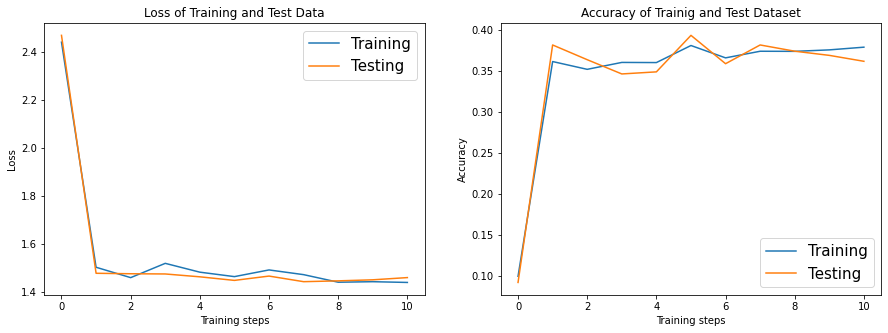

In [42]:
# Visualize accuracy and loss for training and test data

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# One plot training and test loss
axes[0].plot(train_losses, label="Training")
axes[0].plot(test_losses, label="Testing")
axes[0].set(title="Loss of Training and Test Data", xlabel="Training steps", ylabel="Loss")
axes[0].legend(fontsize=15)

# One plot training and test accuracy
axes[1].plot(train_accuracies, label="Training")
axes[1].plot(test_accuracies, label="Testing")
axes[1].set(title="Accuracy of Trainig and Test Dataset", xlabel="Training steps", ylabel="Accuracy")
axes[1].legend(fontsize=15)
plt.show()